## Example strategy
This is a full example strategy showcasing flexible gating of a sample along lymphocyte and T-lymphocyte lineages.

In [1]:
import aligater as ag
import sys
import time

AliGater started in Jupyter mode


In [2]:
def create_vPL(startx,endx, starty,endy, bins=300):
    x_coord=[]
    y_coord=[]
    xstep=(endx-startx)/bins
    ystep=(endy-starty)/bins
    for i in ag.np.arange(startx,endx,xstep):
        x_coord.append(i)
    for i in ag.np.arange(starty,endy,ystep):
        y_coord.append(i)
    assert len(x_coord)==len(y_coord)
    vPL = ag.np.column_stack([x_coord,y_coord])
    return vPL

def CD4gate(fcs, gate, manual_xlim=None, manual_ylim_left=None, manual_ylim_right=None, fileName=None):
    xlim=ag.valleySeek(fcs,"CD45RO",gate,interval=[500,2000],scale='logish')
    ylim=ag.valleySeek(fcs, "CD45RA",gate,interval=[500,1000],scale='logish') #Change 2000 -> 1000 from phase I > phase II
    solution=ag.variableQuadGate(fcs, ['','','',''],"CD45RO",CD45RA,parentGate=gate,scale='logish',threshList=[xlim,xlim,ylim,ylim],testRange=[0,1000],position='left',only_solution=True)
    testUpperLim=1500
    testLowLim=500
    naiveCD4, tmp1, memoryCD4, tmp2, solution=ag.variableQuadGate(fcs,['naiveCD4', 'tmp1', 'memoryCD4', 'tmp2'],"CD45RO",CD45RA,parentGate=gate,scale='logish',threshList=solution,testRange=[testLowLim,testUpperLim],position='right',only_solution=False, filePlot=fileName)
    while len(memoryCD4()) < 0.4*len(tmp1()):
        solution[3]+=500
        testUpperLim=solution[3]+1000
        testLowLim=solution[3]
        naiveCD4, tmp1, memoryCD4, tmp2, solution=ag.variableQuadGate(fcs,['naiveCD4', 'tmp1', 'memoryCD4', 'tmp2'],"CD45RO",CD45RA,parentGate=gate,scale='logish',threshList=solution,testRange=[testLowLim,testUpperLim],position='right',only_solution=False, filePlot=fileName)
    if manual_xlim is not None:
        #In order; bottom x threshold, top x threshold, left y threshold, right y threshold.
        solution[0] = solution[1] = manual_xlim
    if ylim_left is not None:
        solution[2]=manual_ylim_left
    if ylim_right is not None:
        solution[3]=manual_ylim_right
    if any([x is not None for x in [manual_xlim, manual_ylim_left, manual_ylim_right]]):
        threshList = solution[0:4]
        naiveCD4, tmp1, memoryCD4, tmp2 = ag.customQuadGate(fcs,names=['naiveCD4', 'tmp1', 'memoryCD4', 'tmp2'],threshList=threshList ,xCol="CD45RO",yCol=CD45RA,parentGate=gate, scale='logish', filePlot=fileName)
    return naiveCD4, memoryCD4

def FMOCD39(fcs,gate):
    output=ag.gateThreshold(fcs, xCol=CD39,yCol="FSC 488/10-H",name="CD39FMO",parentGate=gate,orientation='vertical', scale='logish',thresh=700,population='upper',update=False, IgnoreCellLimit=False)
    return output

In [3]:
#Defining some comfy marker aliases
SSC="SSC 488/10-A"
FSC="FSC 488/10-A"
CD39="BB515 CD39-A"
CD25="PE-Cy7 CD25-A"
CD127="PE CD127-A"
CCR6="PE-Dazzle 594 CCR6-A"
HLADR="BV650 HLA-DR-A"
CCR7="BV711 CCR7-A"
CXCR5="BV786 CXCR5-A"
CXCR3="BV421 CXCR3-A"
CD194="BV605 CD194-A"
CD4="BV510 CD4-A"
CD3="Alexa Fluor 700 CD3-A"
CD8="APC-H7 CD8-A"
CD45RA="APC CD45RA-A"

In [4]:
T_exp=ag.AGExperiment("/media/ludvig/cbio3/data/BloodVariome/Phase III/", filters=["T Panel"], mask=["fcs_oldstyle"] , compList=[], experiment_name="Phase_III/TCell_P3_17-02-2020.txt", flourochrome_area_filter=True, QC=False)

1 filter(s) defined
1 mask(s) defined
Collected 6767 files, 7477 files did not pass filter(s) and mask(s).


In [27]:
#fcs=ag.loadFCS(T_exp.fcsList[1060],flourochrome_area_filter=True, compensate=True, metadata=False, return_type="agsample")
fcs=ag.loadFCS(ag.AGConfig.ag_home + "tutorial/data/example1.fcs",flourochrome_area_filter=True, compensate=True, metadata=False, return_type="agsample")

Opening file example1 from folder /tutorial/data
Loaded dataset with 1000000 events.


In [6]:
date_plate = ag.getFileName(ag.getParent(fcs.filePath))
date = date_plate.split('-T Panel-')[0]
plate = date_plate.split('-T Panel-')[1]
sampleName=ag.getFileName(fcs.filePath)

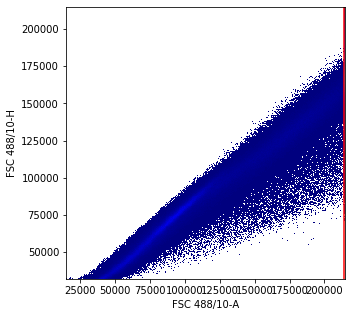

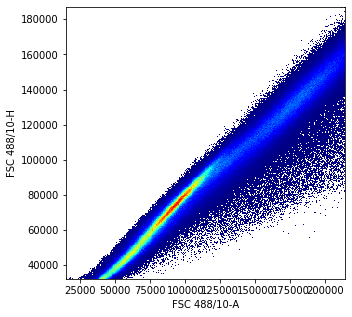

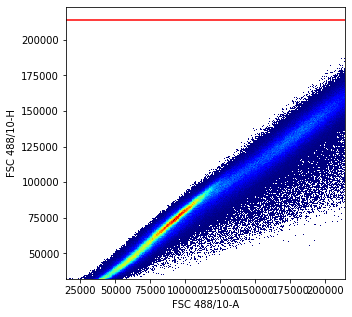

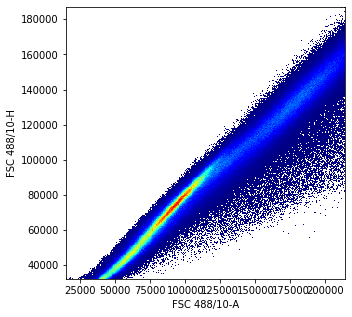

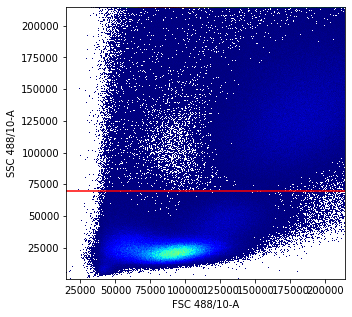

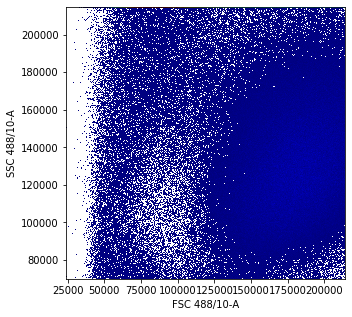

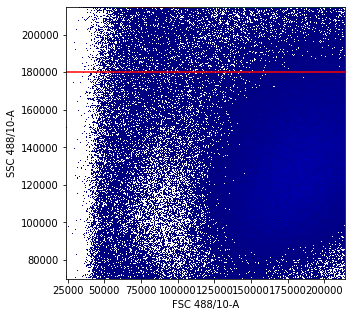

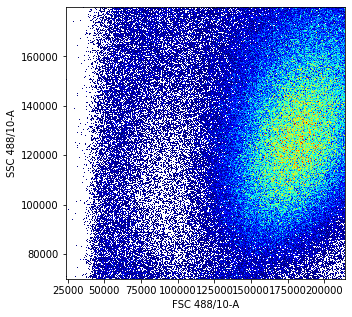

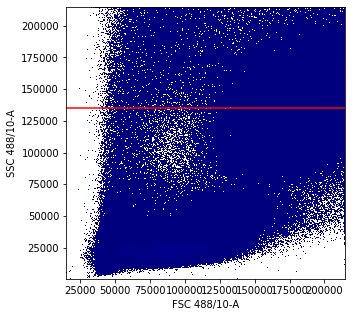

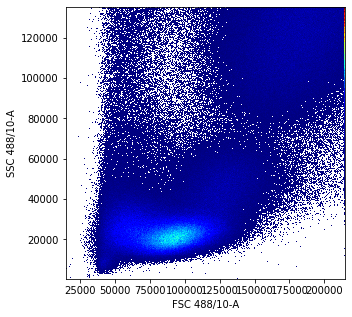

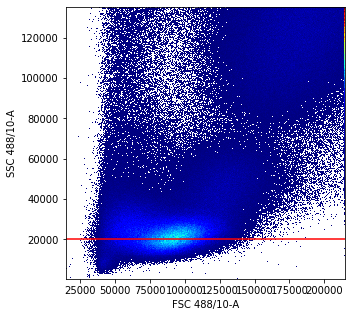

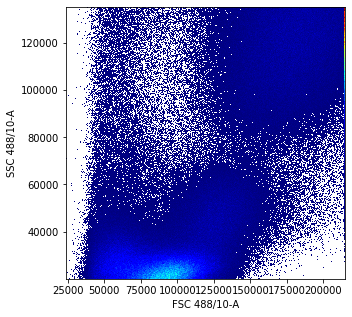

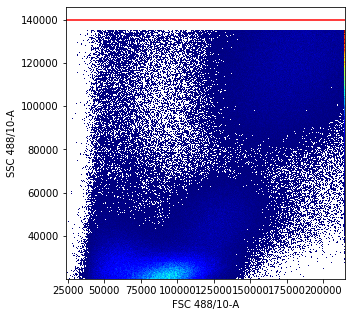

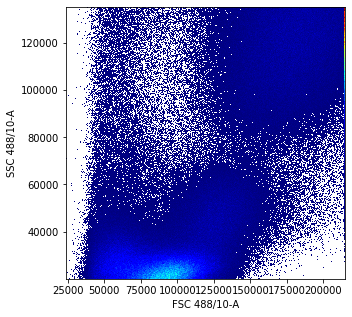

<Figure size 360x360 with 0 Axes>

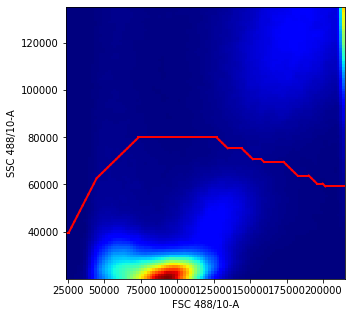

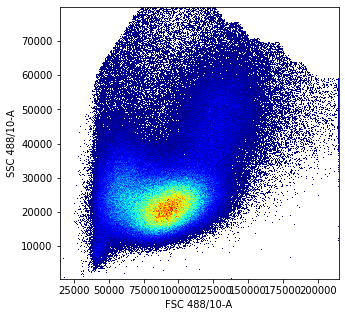

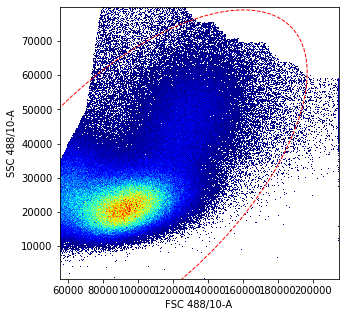

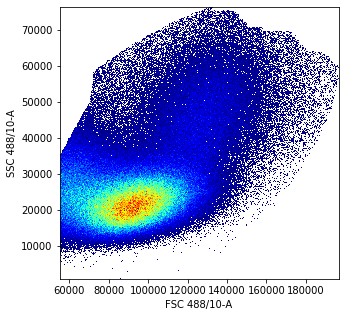

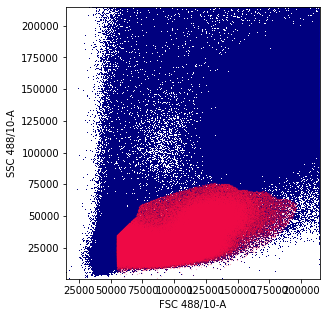

In [29]:
no_clutter1=ag.gateThreshold(fcs,"no_clutter","FSC 488/10-A", "FSC 488/10-H",thresh=214000, orientation='vertical',population="lower")
no_clutter=ag.gateThreshold(fcs,"no_clutter","FSC 488/10-A", "FSC 488/10-H", parentGate=no_clutter1,thresh=214000, orientation='horisontal',population="lower")

PBMCstep1=ag.gateThreshold(fcs,name="PBMCstep1",xCol=FSC,yCol=SSC, parentGate=no_clutter,orientation="horisontal",thresh=70000,population="upper",update=False)
PBMCstep2=ag.gateThreshold(fcs,name="PBMCstep1",xCol=FSC,yCol=SSC, parentGate=PBMCstep1,orientation="horisontal",thresh=180000,population="lower",update=False)
neutrofil_cutoff=ag.getHighestDensityPoint(fcs,FSC,SSC,parentGate=PBMCstep2)[1]
PBMCstep3=ag.gateThreshold(fcs,name="PBMCstep1",xCol=FSC,yCol=SSC, parentGate=None,orientation="horisontal",thresh=neutrofil_cutoff,population="lower",update=False)

PBMCstep4 = ag.horisontalPath(fcs, name="PBMCstep4", xCol=FSC, yCol=SSC, parentGate=PBMCstep3, population='lower',
             startY=40000,endY=60000, xboundaries=None, yboundaries=[20000,140000], leftRight=True , direction='both', maxStep=2, phi=0.1,
             bins=100, sigma=1, scale='linear', T=1000)

vPL=[[55000,0],[55000,35000]]
vPL2 = create_vPL(55000,70000,35000,50000)
vPL3 = create_vPL(70000,90000,50000,120000)
vPL.extend(vPL2)
vPL.extend(vPL3)
vI=ag.gatePointList(fcs(), xCol=FSC, yCol=SSC, vPL=vPL, population='upper',vI=PBMCstep4(), bHorisontal=False)
PBMCstep5=ag.AGgate(vI, PBMCstep4, xCol=FSC, yCol=SSC, name="PBMCstep5")

PBMC=ag.gatePC(fcs,name="PBMC",xCol=FSC,yCol=SSC,center='centroid', adjustAngle=3,widthScale=4, heightScale=3.5, parentGate=PBMCstep5)

ag.backGate(fcs,population=PBMC,background_population=None,xCol=FSC, yCol=SSC,markersize=0.1)

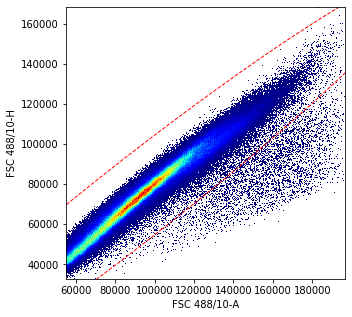

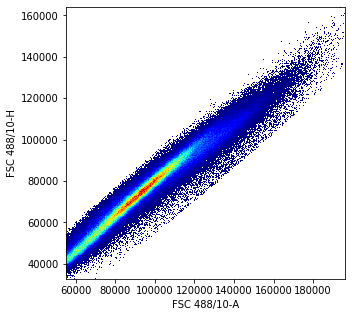

<Figure size 360x360 with 0 Axes>

In [30]:
singlets=ag.gatePC(fcs,xCol=FSC, yCol="FSC 488/10-H",name="singlets",center='density', adjustAngle=1, widthScale=6, heightScale=4.5, parentGate=PBMC)

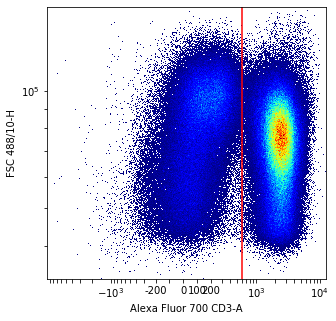

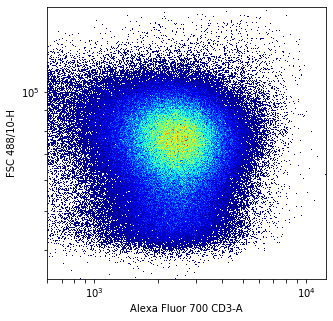

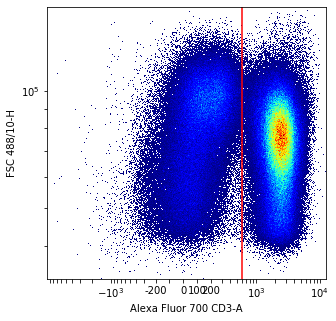

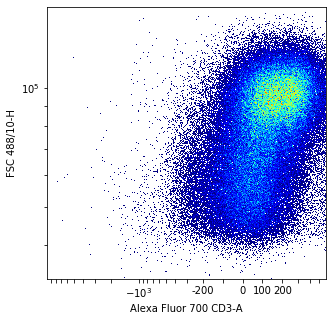

In [31]:
#CD3pos/neg
xlim=ag.valleySeek(fcs=fcs, xCol=CD3, parentGate=singlets, interval=[0,1000], require_local_min=True, scale='bilog',T=200)
if xlim == ag.np.inf:
    xlim=400
CD3pos = ag.gateThreshold(fcs=fcs, name='CD3pos', xCol=CD3, yCol="FSC 488/10-H", parentGate=singlets, thresh=xlim, population='upper', scale='bilog', T=200)
CD3neg = ag.gateThreshold(fcs=fcs, name='CD3pos', xCol=CD3, yCol="FSC 488/10-H", parentGate=singlets, thresh=xlim, population='lower', scale='bilog', T=200)

<Figure size 360x360 with 0 Axes>

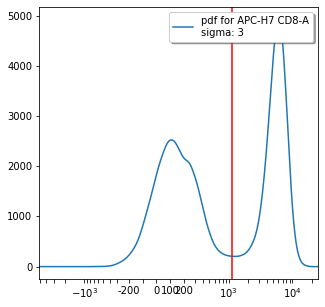

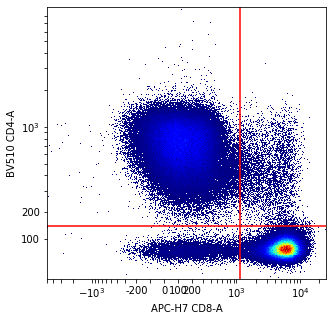

In [32]:
#CD4/CD8
xlim=ag.valleySeek(fcs, xCol=CD8, parentGate=CD3pos, interval=[0,3000], require_local_min=True, scale='bilog',T=200)
if xlim == ag.np.inf:
    xlim=1500
CD8neg_tmp = ag.gateThreshold(fcs=fcs, name='CD8neg_temp', xCol=CD8, parentGate=CD3pos, thresh=xlim, population='lower', scale='bilog',T=200)
ylim=ag.valleySeek(fcs, xCol=CD4, parentGate=CD8neg_tmp, interval=[50,1000], require_local_min=True, scale='bilog',T=200)
if ylim == ag.np.inf:
    ylim=200
if ylim < 100: # shouldnt flop down all the way here
    ylim=200 #set to ~fmo
CD4pos,CD4CD8_doublepos,CD8pos,CD4neg = ag.quadGate(fcs, names=["","", "", ""], xCol=CD8, yCol=CD4, parentGate=CD3pos, xThresh=xlim, yThresh=ylim, scale='bilog',T=200)
#ag.plotHeatmap(fcsDF=fcs(), x=CD8, y=CD4, vI=CD3pos(), scale='bilog', T=200)

<Figure size 360x360 with 0 Axes>

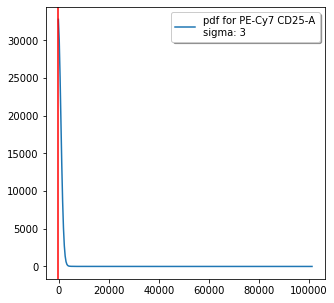

<Figure size 360x360 with 0 Axes>

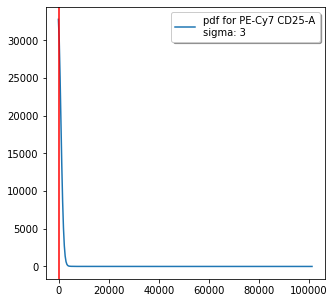

<Figure size 360x360 with 0 Axes>

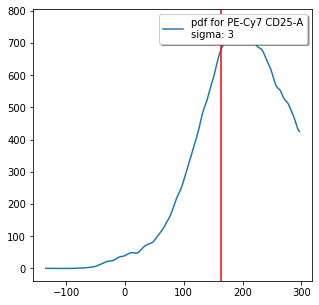

<Figure size 360x360 with 0 Axes>

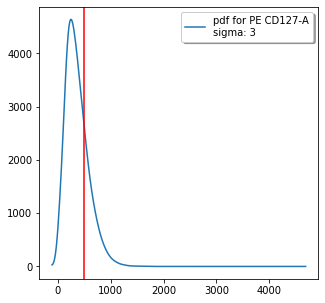

<Figure size 360x360 with 0 Axes>

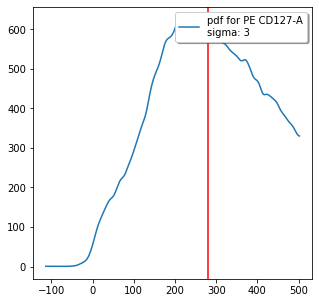

<Figure size 360x360 with 0 Axes>

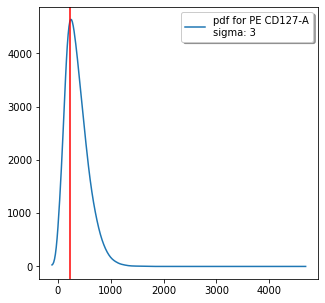

<Figure size 360x360 with 0 Axes>

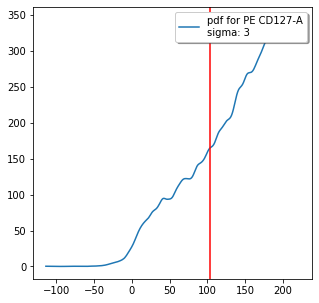

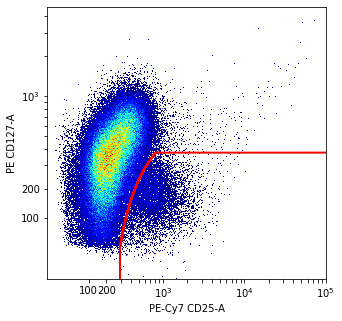

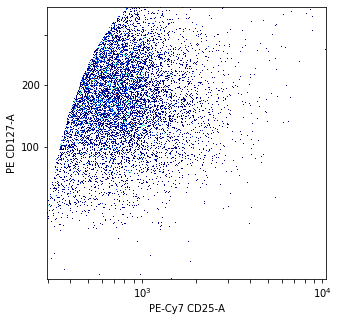

In [53]:
CD4pos_hiCD25 = ag.gateThreshold(fcs, name="tmp", xCol=CD25, parentGate=CD4pos, thresh=-200, population='upper')
mean,median, sigma, maxVal=ag.axisStats(fcsDF=fcs(),xCol=CD25, vI=CD4pos_hiCD25(),scale='bilog',T=200)

lim_upper = ag.inverseTransformWrapper(maxVal+0.5*abs(sigma),scale='bilog',T=200)
lim_lower = ag.inverseTransformWrapper(maxVal-0.5*abs(sigma),scale='bilog',T=200)

xmaxVal=lim_upper
tmp_maxCD25=ag.gateThreshold(fcs, name="tmp", xCol=CD25,parentGate=CD4pos, thresh=lim_upper, population='lower')
maxCD25=ag.gateThreshold(fcs, name="tmp", xCol=CD25, parentGate=tmp_maxCD25, thresh=lim_lower, population='upper')

ylim=ag.densityDelimitation(fcs=fcs, xCol=CD127, parentGate=maxCD25, interval=[-200,1000], limit_threshold=0.05, direction='left',scale='bilog',T=200)


mean,median, sigma, maxVal=ag.axisStats(fcsDF=fcs(),xCol=CD127, vI=CD4pos(),scale='bilog',T=200)

lim_upper = ag.inverseTransformWrapper(maxVal+0.5*abs(sigma),scale='bilog',T=200)
lim_lower = ag.inverseTransformWrapper(maxVal-0.5*abs(sigma),scale='bilog',T=200)
ymaxVal=ag.inverseTransformWrapper(maxVal,scale='bilog',T=200)

tmp_maxCD127=ag.gateThreshold(fcs, name="tmp", xCol=CD127,parentGate=CD4pos, thresh=lim_upper, population='lower')
maxCD127=ag.gateThreshold(fcs, name="tmp", xCol=CD127, parentGate=tmp_maxCD127, thresh=lim_lower, population='upper')

xlim=ag.densityDelimitation(fcs=fcs, xCol=CD25, parentGate=maxCD127, interval=[200,10000], limit_threshold=0.05, direction='right',scale='bilog',T=200)

if ymaxVal<0:
    ymaxVal=0
if ymaxVal>700:
    ymaxVal=700

bezierXParam = [0.7]
bezierYParam = [0.3]
#Take midpoint between ylim and ymaxVal (ymaxval >> ylim) in transformed coordinates
#Midpoint in transformed coordinates (!)
tyMid = (ag.transformWrapper([ymaxVal], T=200, scale='bilog')[0] + ag.transformWrapper([ylim], T=200, scale='bilog')[0])/2
#Copy code from above to make a 'street' and calc density delim (we have already calced mean and sigma)
lim_upper = ag.inverseTransformWrapper(tyMid+0.5*abs(sigma),scale='bilog',T=200)
lim_lower = ag.inverseTransformWrapper(tyMid-0.5*abs(sigma),scale='bilog',T=200)    

tmp_midCD127=ag.gateThreshold(fcs, name="tmp", xCol=CD127,parentGate=CD4pos, thresh=lim_upper, population='lower')
midCD127=ag.gateThreshold(fcs, name="tmp", xCol=CD127, parentGate=tmp_midCD127, thresh=lim_lower, population='upper')
xMid=ag.densityDelimitation(fcs=fcs, xCol=CD25, parentGate=midCD127, interval=[-200,10000], limit_threshold=0.3, direction='right',scale='bilog',T=200)
#See which percent this xMid is at from relative to xlim and xmaxVal (xlim >> xmaxVal)
fraction_traveled_x = (xMid-xmaxVal)/(xlim-xmaxVal)

if fraction_traveled_x < 0.30:
    #Curve inward
    bezierXParam = [0.3]
    bezierYParam = [0.7]
elif fraction_traveled_x > 0.70:
    #curve_outward
    bezierXParam = [0.7]
    bezierYParam = [0.3]
else:
    #straight
    bezierXParam = [0.5]
    bezierYParam = [0.5]
Tregs=ag.gateBezier(fcs,name="tmp", xCol=CD25, yCol=CD127, endExtension='right', startExtension='down', population='lower', parentGate=CD4pos, points=[(xmaxVal,ylim),(xlim,ymaxVal)], xParam=bezierXParam, yParam=bezierYParam, scale='bilog', T=200)

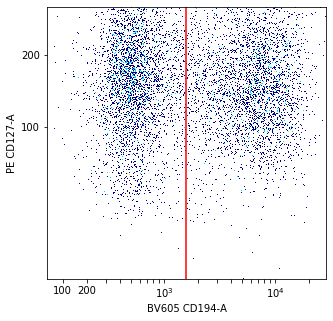

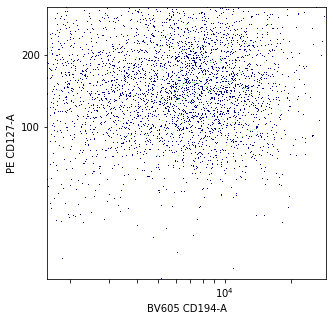

In [34]:
#Tregs #2, 'CD194+ tregs'
xlim=ag.valleySeek(fcs, xCol=CD194, parentGate=Tregs,interval=[500,5000], require_local_min=True, sigma=3, scale='bilog', T=200)
if xlim == ag.np.inf:
    xlim=1500
CD194_Tregs = ag.gateThreshold(fcs=fcs, name="CD194_Tregs", xCol=CD194, yCol=CD127, parentGate=Tregs, thresh=xlim, orientation='vertical', scale='bilog', T=200, population='upper')

In [35]:
#Tregs #3, subpopulations

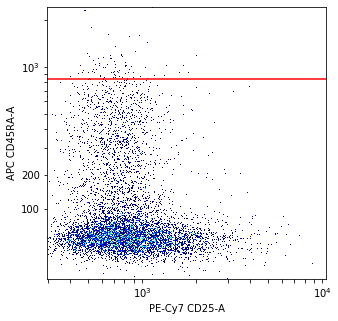

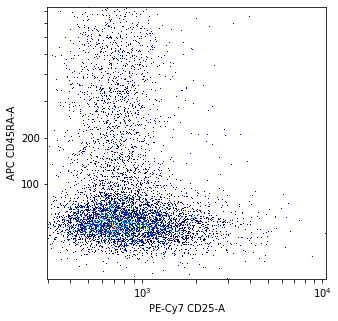

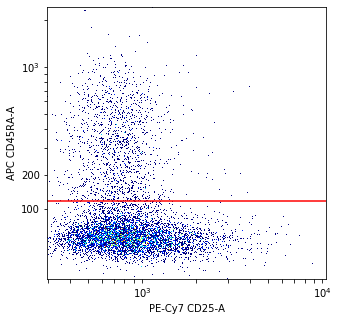

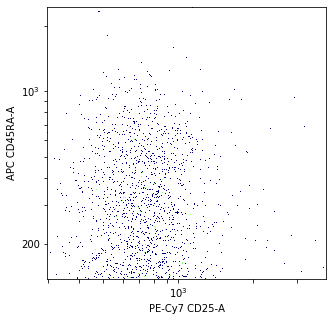

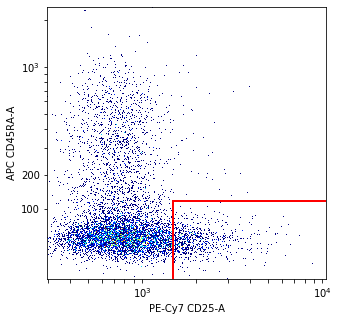

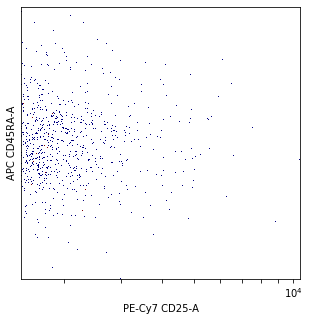

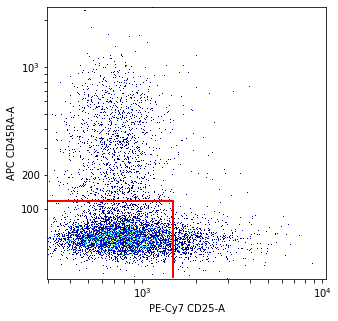

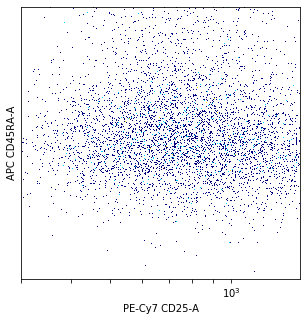

In [36]:
#Tregs subpopulations - activated, secreting, resting
#First gate out the resting (top) by estimating half-normal distribution on bottom cluster. 
#Then look at the CD25 expression of these resting Tregs, and set the limit between secreting and activated Tregs 
#at some point of the right-tail of the CD25 distribution

#First do arbitrary cut in the y-axis somewhere between 0-1000
ylim=ag.valleySeek(fcs,xCol=CD45RA,parentGate=Tregs,interval=[0,1000],scale='bilog', T=200)
tmpbottomTreg = ag.gateThreshold(fcs,xCol=CD25,yCol=CD45RA,name="bottomTreg",parentGate=Tregs, thresh = ylim, population='lower',orientation='horisontal',scale='bilog', T=200,update=False)
#In this population, find the most dense point
tmp, tmp1, tmp2, maxVal=ag.axisStats(fcs(),xCol=CD45RA,vI=tmpbottomTreg(),scale='bilog', T=200)
maxVal = ag.inverseTransformWrapper(maxVal, scale='bilog', T=200)
mean, sigma = ag.halfNormalDistribution(fcs, xCol=CD45RA, mean=maxVal, direction='left', parentGate=tmpbottomTreg, scale='bilog', T=200)
#Now we can set the final ylim with big margin (4 std devs):
ylim = ag.inverseTransformWrapper(mean + 4*abs(sigma), scale='bilog', T=200)
if ylim > 1000:
    ylim = 1000
if ylim < 100:
    ylim = 100
#We use this to gate the activated Tregs
restingTreg = ag.gateThreshold(fcs, xCol=CD25, yCol=CD45RA, name="restingTreg", thresh=ylim, parentGate=Tregs, scale='bilog', T=200, population='upper', orientation='horisontal', update=False, filePlot=None)

#We then investigate the CD25 distribution in this population and set the treshold at one standard dev on the right tail
mean, median, sigma, maxVal = ag.axisStats(fcs(), xCol=CD25, vI=restingTreg(), scale='bilog', T=200)
#With this we can set the final xlim
xlim = mean + 2*sigma
xlim = ag.inverseTransformWrapper(xlim,scale='bilog', T=200)
if xlim > 10000:
    xlim = 10000
if xlim < 1000:
    xlim = 1000
activatedTreg = ag.gateCorner(fcs, name="activatedTreg", xCol=CD25, yCol=CD45RA, xThresh=xlim, yThresh=ylim, xOrientation="upper", yOrientation="lower", parentGate=Tregs, scale='bilog', T=200, filePlot=None)   
secretingTreg = ag.gateCorner(fcs, name="secretingTreg", xCol=CD25, yCol=CD45RA, xThresh=xlim, yThresh=ylim, xOrientation="lower", yOrientation="lower", parentGate=Tregs, scale='bilog',T=200, filePlot=None)

In [37]:
#OTHER CD4pos 'branch'
#Th1, Th2, Th17

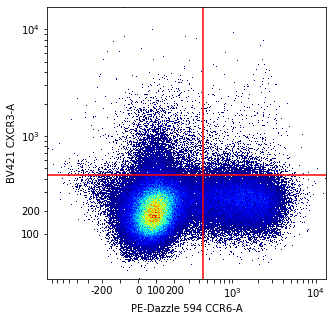

In [38]:
follicular_xlim = ag.valleySeek(fcs, xCol=CCR6, interval=[0,1000], require_local_min=True, parentGate=CD4pos, scale='bilog', T=200, sigma=2)
follicular_ylim = ag.densityDelimitation(fcs, xCol=CXCR3, parentGate=CD4pos, limit_threshold=0.2, scale='bilog', T=200, direction='right', interval=[100,1000],sigma=1)
Th1, Th2, Th1_Th17, Th17 = ag.quadGate(fcs=fcs, names=['Th1', 'Th2', 'Th1_Th17', 'Th17'], xCol=CCR6, yCol=CXCR3, xThresh=follicular_xlim, yThresh=follicular_ylim, parentGate=CD4pos, scale='bilog', T=200)

<Figure size 360x360 with 0 Axes>

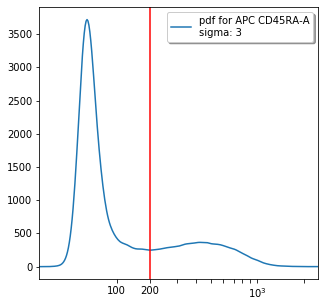

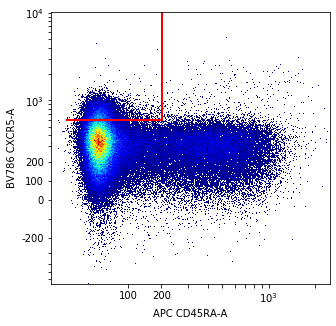

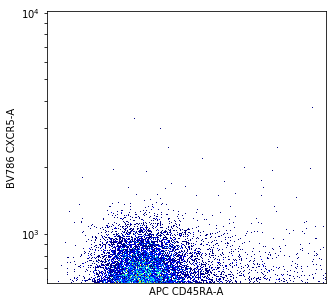

In [39]:
#Further, parent CD4pos still
xlim = ag.valleySeek(fcs, xCol=CD45RA, parentGate=CD4pos,interval=[0,700], require_local_min=True,sigma=3,scale='bilog',T=200)

if xlim == ag.np.inf:
    xlim=200
if xlim < 200:
        xlim=200    
tmpHiCD45RA = ag.gateThreshold(fcs,xCol=CD45RA,name="tmpHiCD45RA",parentGate=CD4pos, thresh = xlim, population='upper',orientation='vertical',scale='bilog', T=200,update=False)
ylim = ag.densityDelimitation(fcs, xCol=CXCR5, parentGate=tmpHiCD45RA, interval=[0,2500], direction='right',limit_threshold=0.1, scale='bilog',T=200)

CXCR5pos = ag.gateCorner(fcs, name='CXCR5pos', xCol=CD45RA, yCol=CXCR5, parentGate=CD4pos, xThresh=xlim, yThresh=ylim, xOrientation='lower', yOrientation='upper', scale='bilog', T=200)

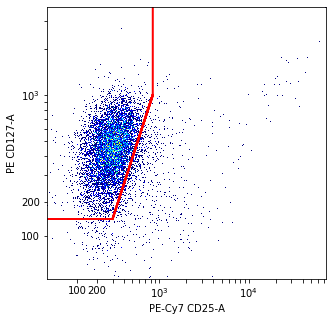

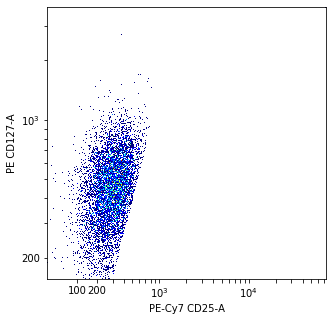

In [40]:
xlim = ag.densityDelimitation(fcs, xCol=CD25, parentGate=CXCR5pos, interval=[0,3000], direction='right',limit_threshold=0.05, scale='bilog',T=200)
if xlim == ag.np.inf:
    xlim=500
ylim = ag.densityDelimitation(fcs, xCol=CD127, parentGate=CXCR5pos, interval=[0,2000], direction='left',limit_threshold=0.1, scale='bilog',T=200)
if ylim == ag.np.inf:
    ylim=300
Follicular_Th = ag.gateBezier(fcs, name='some_TH', xCol=CD25, yCol=CD127, parentGate=CXCR5pos, endExtension='up', startExtension='left',points=[(300,ylim),(xlim,1000)], population='upper', xParam=[0.8], yParam=[0.8], scale='bilog', T=200)

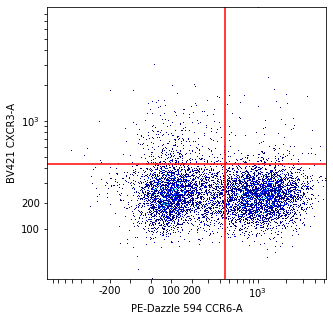

In [41]:
#USES THE X AND Y LIMITS FROM THE TH1,TH17, GATE (two steps up!) 
#Most samples too sparse to do stable pattern recognition here
Follicular_th1, Follicular_th1_th17, Follicular_th17, Follicular_Th2 = ag.quadGate(fcs=fcs, names=['Follicular_th1', 'Follicular_th1-th17', 'Follicular_th17', 'Follicular_Th2'], xCol=CCR6, yCol=CXCR3, xThresh=follicular_xlim, yThresh=follicular_ylim, parentGate=Follicular_Th, scale='bilog', T=200)

In [42]:
#CD4+ BLOCK (effector etc)

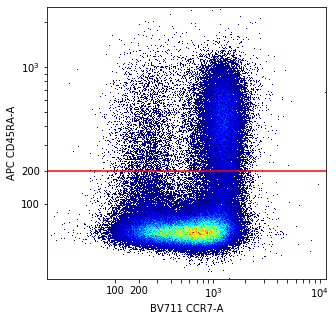

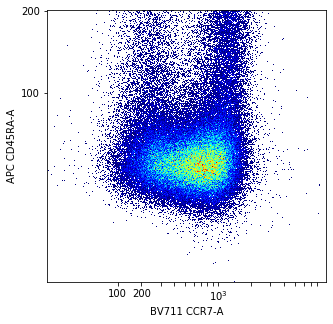

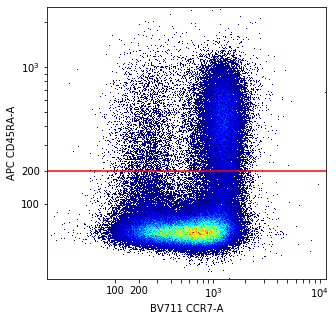

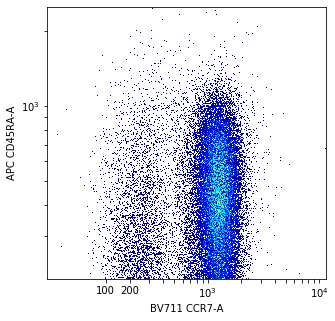

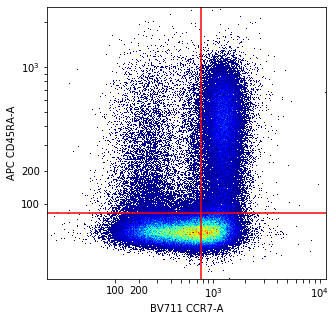

In [43]:
#Find initial top-bottom rough separation
ylim = ag.valleySeek(fcs, xCol=CD45RA, interval=[0,800], require_local_min=True, parentGate=CD4pos, scale='bilog', T=200)
if ylim == ag.np.inf:
    ylim=200
    bNoYlimSep=True
else:
    bNoYlimSep=False
if ylim < 200:
    ylim=200

tempCD4quad_bottom = ag.gateThreshold(fcs,xCol=CCR7, yCol=CD45RA,name="bottomTmp",parentGate=CD4pos, thresh = ylim, population='lower',orientation='horisontal',scale='bilog', T=200,update=False)
tempCD4quad_top = ag.gateThreshold(fcs,xCol=CCR7, yCol=CD45RA,name="topTmp",parentGate=CD4pos, thresh = ylim, population='upper',orientation='horisontal',scale='bilog', T=200,update=False)

#Fine adjust limits based on those two clusters
if bNoYlimSep: #If no proper separation of clusters - increase the density delim (see i.e. sample 9621153)
    ylim = ag.densityDelimitation(fcs, xCol=CD45RA, interval=[0,1000], direction='right', limit_threshold=0.5, parentGate=tempCD4quad_bottom, scale='bilog', T=200)
else:
    ylim = ag.densityDelimitation(fcs, xCol=CD45RA, interval=[0,1000], direction='right', limit_threshold=0.2, parentGate=tempCD4quad_bottom, scale='bilog', T=200)
if ylim == ag.np.inf:
    ylim=200

xlim = ag.densityDelimitation(fcs, xCol=CCR7, interval=[500,2000], direction='left', limit_threshold=0.2, parentGate=tempCD4quad_top, scale='bilog', T=200)
if xlim == ag.np.inf:
    xlim=600
#Gate
effector_CD4pos, naive_CD4pos, central_memory_CD4pos, effector_memory_CD4pos = ag.quadGate(fcs=fcs, names=['effector_CD4pos', 'naive_CD4pos', 'central_memory_CD4pos', 'effector_memory_CD4pos'], xCol=CCR7, yCol=CD45RA, xThresh=xlim, yThresh=ylim, parentGate=CD4pos, scale='bilog', T=200)

<Figure size 360x360 with 0 Axes>

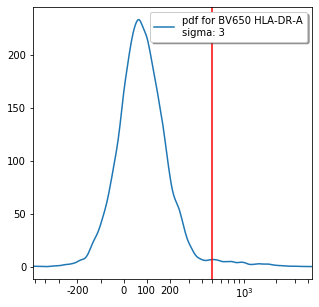

<Figure size 360x360 with 0 Axes>

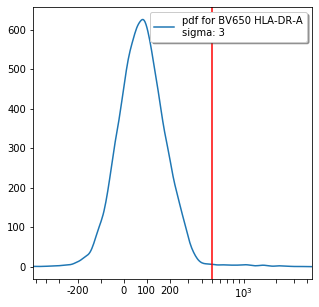

<Figure size 360x360 with 0 Axes>

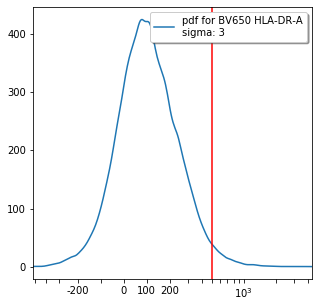

<Figure size 360x360 with 0 Axes>

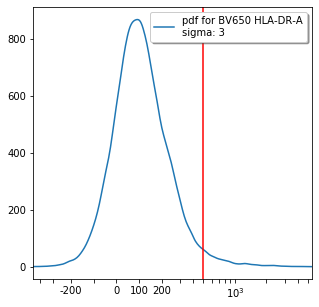

In [44]:
effector_CD4pos_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="effector_CD4pos_HLADRpos",parentGate=effector_CD4pos, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)
naive_CD4pos_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="naive_CD4pos_HLADRpos",parentGate=naive_CD4pos, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)
central_memory_CD4pos_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="central_memory_CD4pos_HLADRpos",parentGate=central_memory_CD4pos, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)
effector_memory_CD4pos_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="effector_memory_CD4pos_HLADRpos",parentGate=effector_memory_CD4pos, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)

In [45]:
#CD8 BLOCK

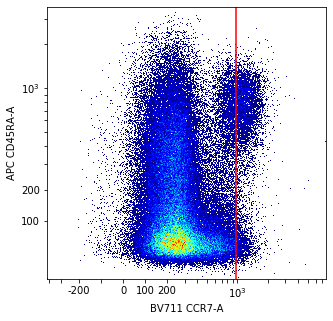

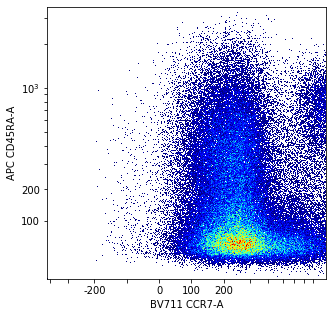

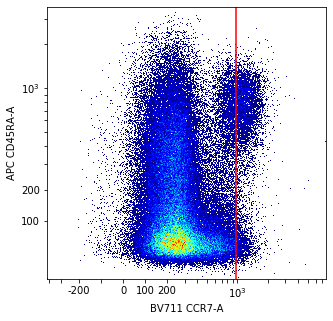

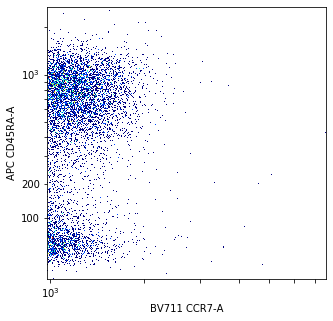

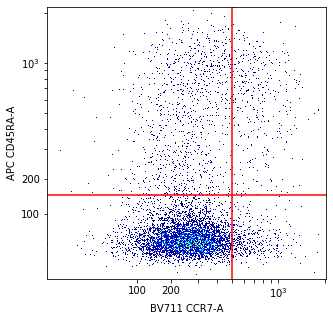

In [46]:
#Find initial top-bottom rough separation

xlim = ag.valleySeek(fcs, xCol=CCR7, interval=[200,1500], require_local_min=True, parentGate=CD8pos, scale='bilog', T=200)
if xlim == ag.np.inf:
    xlim=500
if xlim < 500:
    xlim=500

tempCD8quad_left = ag.gateThreshold(fcs,xCol=CCR7, yCol=CD45RA,name="leftTmp",parentGate=CD8pos, thresh = xlim, population='lower',orientation='vertical',scale='bilog', T=200,update=False)
tempCD8quad_right = ag.gateThreshold(fcs,xCol=CCR7, yCol=CD45RA,name="rightTmp",parentGate=CD8pos, thresh = xlim, population='upper',orientation='vertical',scale='bilog', T=200,update=False)

#Fine adjust limits based on those two clusters
ylim = ag.densityDelimitation(fcs, xCol=CD45RA, interval=[0,800], direction='right', limit_threshold=0.3, parentGate=tempCD8quad_left, scale='bilog', T=200)
if ylim == ag.np.inf:
    ylim=200
#Also check density delimitation using the right half of the cluster
#Reasoning:
#If the left half of the quad is 'smeared' and the right half is quite dense (see sample 9704538)
#Then the ylim based on the right half makes more sense
#Check using that side. If that limit is closer to 200 (the 'default'/fmo) and hasn't hit rock bottom (<100)
#Then use that instead, it's probably better.
#If that side is also smeared, its probably a bad sample...
ylim_alternate = ag.densityDelimitation(fcs, xCol=CD45RA, interval=[0,800], direction='left', limit_threshold=0.3, parentGate=tempCD8quad_right, scale='bilog', T=200)    
if ylim != ag.np.inf:
    if abs(ylim_alternate - 200) < abs(ylim - 200) and ylim_alternate > 100:
        ylim=ylim_alternate

xlim = ag.densityDelimitation(fcs, xCol=CCR7, interval=[0,1500], direction='left', limit_threshold=0.2, parentGate=tempCD8quad_right, scale='bilog', T=200)
if xlim == ag.np.inf:
    xlim=500
effector_CD4neg, naive_CD4neg, central_memory_CD4neg, effector_memory_CD4neg = ag.quadGate(fcs=fcs, names=['effector_CD4neg', 'naive_CD4neg', 'central_memory_CD4neg', 'effector_memory_CD4neg'], xCol=CCR7, yCol=CD45RA, xThresh=xlim, yThresh=ylim, parentGate=CD4neg, scale='bilog', T=200)

<Figure size 360x360 with 0 Axes>

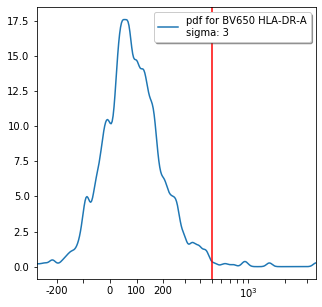

<Figure size 360x360 with 0 Axes>

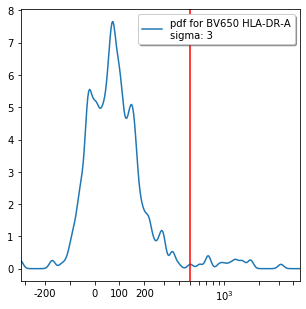

<Figure size 360x360 with 0 Axes>

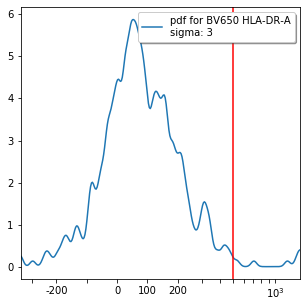

<Figure size 360x360 with 0 Axes>

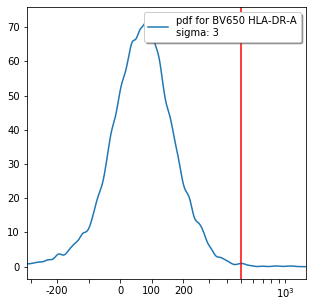

In [47]:
effector_CD4neg_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="effector_CD4neg_HLADRpos",parentGate=effector_CD4neg, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)
naive_CD4neg_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="naive_CD4neg_HLADRpos",parentGate=naive_CD4neg, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)
central_memory_CD4neg_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="central_memory_CD4neg_HLADRpos",parentGate=central_memory_CD4neg, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)
effector_memory_CD4neg_HLADRpos = ag.gateThreshold(fcs,xCol=HLADR,name="effector_memory_CD4neg_HLADRpos",parentGate=effector_memory_CD4neg, thresh = 500, population='upper',orientation='vertical',scale='bilog', T=200,update=False)

In [48]:
#DONE